## Subsampling analysis

subsample the number of inidvidualas/RNA-seq datasets and look at how number of signals changes

In [52]:
import pandas as pd
import numpy as np
import os
import yaml
import seaborn as sns
import matplotlib.pyplot as plt


prefix = '/home/klawren/oak/pcqtls'

### create the subsampled expression and covar files
this only needs to be run once

In [27]:
# get outputs from a config file
config_path= f'{prefix}/config/proteincoding_main.yaml'
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

tissue_id_path = config['tissue_id_path']
clusters_dir = config['clusters_dir']
expression_dir = config['expression_dir']
covariates_dir = config['covariates_dir']

tissue_df = pd.read_csv(f"{prefix}/{tissue_id_path}", header=0)
tissue_ids = list(tissue_df['Tissue'])
tissue_id = 'Cells_Cultured_fibroblasts'

In [28]:
# minimum of 300 in each tissue, I'll do 100, 200, 300

for num_samples in [50,100,200, 300]:
    output_dir = f'{prefix}/data/processed/subsampling/{num_samples}'
    os.mkdir(output_dir)
    os.mkdir(f'{output_dir}/covariates/')
    os.mkdir(f'{output_dir}/normalized_expression/')

    for tissue_id in tissue_ids:
        # load in each expression and covariates files
        expression_df = pd.read_csv(f'{prefix}/{expression_dir}/{tissue_id}.v8.normalized_expression.bed', sep='\t')
        covariates_df = pd.read_csv(f'{prefix}/{covariates_dir}/{tissue_id}.v8.covariates.txt', sep='\t', index_col=0).T

        selected_samples = covariates_df.index[:num_samples].values

        # write out first x as a subset
        sub_expression = expression_df[np.concatenate([expression_df.columns[:4].values, selected_samples])]
        sub_expression.to_csv(f'{output_dir}/normalized_expression/{tissue_id}.v8.normalized_expression.bed', sep='\t', index=None)

        sub_covar = covariates_df.loc[selected_samples]
        sub_covar.T.to_csv(f'{output_dir}/covariates/{tissue_id}.v8.covariates.txt', sep='\t')

FileExistsError: [Errno 17] File exists: '/home/klawren/oak/pcqtls/data/processed/subsampling/50'

In [ ]:
# try with a random selection of 100 rather than the first 100
for num_samples in [100]:
    output_dir = f'{prefix}/data/processed/subsampling/{num_samples}_rand'
    try:
        os.mkdir(output_dir)
        os.mkdir(f'{output_dir}/covariates/')
        os.mkdir(f'{output_dir}/normalized_expression/')
    except FileExistsError:
        pass

    for tissue_id in tissue_ids:
        # load in each expression and covariates files
        expression_df = pd.read_csv(f'{prefix}/{expression_dir}/{tissue_id}.v8.normalized_expression.bed', sep='\t')
        covariates_df = pd.read_csv(f'{prefix}/{covariates_dir}/{tissue_id}.v8.covariates.txt', sep='\t', index_col=0).T

        selected_samples = pd.Series(covariates_df.index.values).sample(num_samples)

        sub_expression = expression_df[np.concatenate([expression_df.columns[:4].values, selected_samples])]
        sub_expression.to_csv(f'{output_dir}/normalized_expression/{tissue_id}.v8.normalized_expression.bed', sep='\t', index=None)

        sub_covar = covariates_df.loc[selected_samples]
        sub_covar.T.to_csv(f'{output_dir}/covariates/{tissue_id}.v8.covariates.txt', sep='\t')

I then run snakemake on each of these 4 to get the QTLs with config files in config/subsampling/


this next analysis assumes results in those folders

In [ ]:
subsample_output_folder = f'{prefix}/config/subsampling_constant_clusters'

### Number QTLs across subsamples

In [ ]:
# load in the configs for each 

subsample_nums = [100,200,300]

sub_config = {}
for num_samples in subsample_nums:
    config_path= f'{subsample_output_folder}/{num_samples}_subsample.yaml'
    with open(config_path, 'r') as f:
        config = yaml.safe_load(f)
        sub_config[num_samples] = config

tissue_id_path = config['tissue_id_path']
tissue_df = pd.read_csv(f"{prefix}/{tissue_id_path}", header=0)
tissue_ids = list(tissue_df['Tissue'])
tissue_pal = sns.color_palette('blend:#B83A4B,#FEC51D,#67AFD2', n_colors=len(tissue_ids))


tissue_id = 'Cells_Cultured_fibroblasts'

In [ ]:
# to load the random 100 (rather than 1st 100)
# for num_samples in [101]:
#     config_path= f'{prefix}/config/subsampling/{num_samples-1}_rand_subsample.yaml'
#     with open(config_path, 'r') as f:
#         config = yaml.safe_load(f)
#         sub_config[num_samples] = config

In [ ]:
def get_qtl_counts(tissue_id, config):
    overlap_df = pd.read_csv('{}/{}/{}.v8.overlap.txt'.format(prefix, config['overlap_output_dir'], tissue_id), sep='\t')
    return overlap_df.groupby('orig_cs_dataset').count()['cs_full_id']

def get_cluster_count(tissue_id, config):
    cluster_df = pd.read_csv('{}/{}/{}_clusters_all_chr.csv'.format(prefix, config['clusters_dir'], tissue_id))
    return len(cluster_df)

def get_egene_count(tissue_id, config):
    overlap_df = pd.read_csv('{}/{}/{}.v8.overlap.txt'.format(prefix, config['overlap_output_dir'], tissue_id), sep='\t')
    if len(overlap_df) == 0:
        return 0
    else:
        return len(set(np.concatenate(overlap_df['cluster_id'].str.split('_'))))

def get_counts(config):
    counts = tissue_df['Tissue'].apply(get_qtl_counts, args=(config,))
    counts = tissue_df.join(counts)
    counts['clusters'] = counts['Tissue'].apply(get_cluster_count, args=(config,))
    counts['egenes'] = counts['Tissue'].apply(get_egene_count, args=(config,))
    return counts

In [32]:
sub_counts = []
for num_samples in subsample_nums:
    sub_counts.append(get_counts(sub_config[num_samples]))

In [33]:
joined_count_df = pd.concat(sub_counts, keys=[*subsample_nums, 101], names=['num_samples', 'idx'])
joined_count_df.fillna(0, inplace=True)
joined_count_df.reset_index(level=0, inplace=True)
joined_counts = joined_count_df.melt(id_vars=['Tissue', 'num_samples'], var_name='count_type', value_name='count')

Text(0.5, 0.98, 'Subsampled counts')

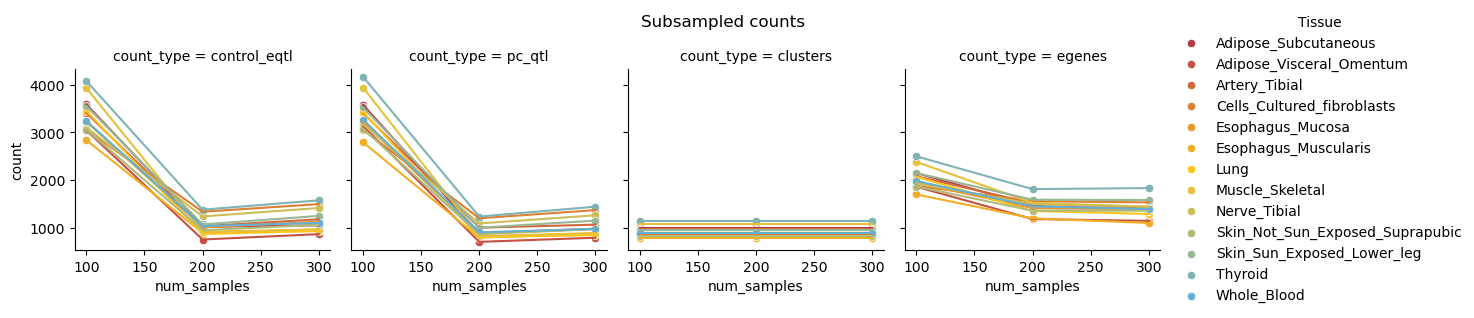

In [35]:
g = sns.FacetGrid(joined_counts, col="count_type", hue='Tissue', palette = tissue_pal)
g.map(sns.lineplot, "num_samples", "count")
g.map(sns.scatterplot, "num_samples", "count")
g.add_legend()
g.fig.subplots_adjust(top=0.8)
g.fig.suptitle('Subsampled counts')

look at p values for each snp

In [106]:
eqtl_output_dir = config['eqtl_output_dir']
pcqtl_output_dir = config['pcqtl_output_dir']

def var_pos(df):
    return df['variant_id'].str.split('_').str[1].astype(int)

# load in e nominal
def load_e_nominal(config, prefix, chr_id=22):
    eqtl_output_dir = config['eqtl_output_dir']
    path = f'{prefix}/{eqtl_output_dir}/{tissue_id}/{tissue_id}.v8.cluster_genes.cis_qtl_pairs.chr{chr_id}.parquet'
    e_nominal_df = pd.read_parquet(path)
    e_nominal_df['variant_pos'] = var_pos(e_nominal_df)
    e_nominal_df['cluster_id'] = e_nominal_df['phenotype_id'].str.split('_e_').str[0]
    return e_nominal_df

def load_pc_nominal(config, prefix, chr_id=22):
    pcqtl_output_dir = config['pcqtl_output_dir']
    path = f'{prefix}/{pcqtl_output_dir}/{tissue_id}/{tissue_id}.v8.pcs.cis_qtl_pairs.chr{chr_id}.parquet'
    pc_nominal_df = pd.read_parquet(path)
    pc_nominal_df['variant_pos'] = var_pos(pc_nominal_df)
    pc_nominal_df['cluster_id'] = pc_nominal_df['phenotype_id'].str[:-4]
    return pc_nominal_df

def load_overlap(config, prefix):
    return pd.read_csv('{}/{}/{}.v8.overlap.txt'.format(prefix, config['overlap_output_dir'], tissue_id), sep='\t')



In [134]:
sub_overlaps = {}
pc_nominals = {}
e_nominals = {}
for num_samples in subsample_nums:
    sub_overlaps[num_samples] = load_overlap(sub_config[num_samples], prefix)
    pc_nominals[num_samples] = load_pc_nominal(sub_config[num_samples], prefix)
    e_nominals[num_samples] = load_e_nominal(sub_config[num_samples], prefix)

In [135]:
e_nominals[100]['is_lead'] = e_nominals[100]['variant_id'].isin(sub_overlaps[100]['lead_variant_id'])
e_nominals[200]['is_lead'] = e_nominals[200]['variant_id'].isin(sub_overlaps[200]['lead_variant_id'])
e_nominal_merged = pd.merge(left=e_nominals[100], right=e_nominals[200],left_on=['phenotype_id', 'variant_id'], right_on=['phenotype_id', 'variant_id'], suffixes=['_100', '_200'])

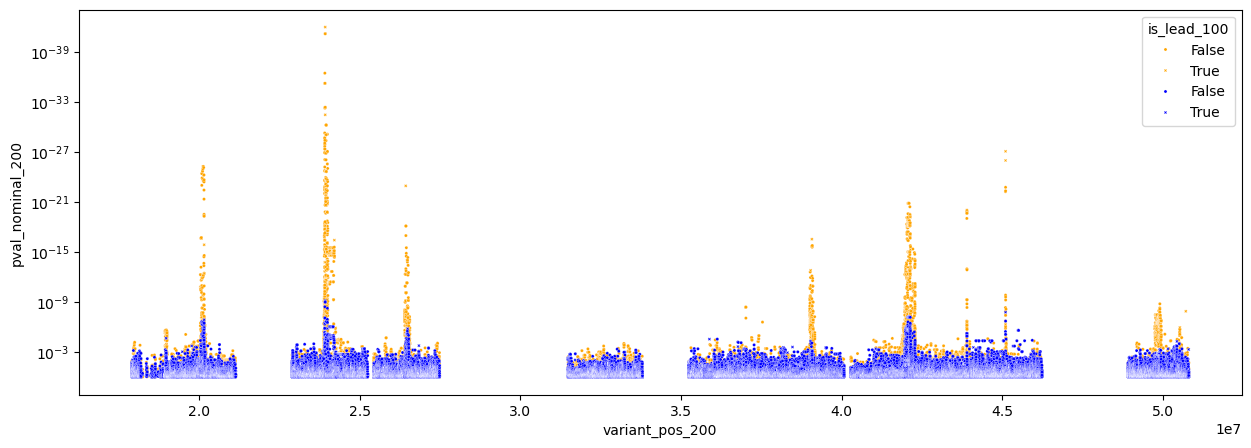

In [136]:
fig, ax = plt.subplots(figsize=(15,5))
sns.scatterplot(e_nominal_merged, y='pval_nominal_200', x='variant_pos_200', ax=ax, color='orange', style='is_lead_200', s=5)
sns.scatterplot(e_nominal_merged, y='pval_nominal_100', x='variant_pos_100', ax=ax, color='blue', style='is_lead_100', s=5)

ax.set_yscale('log')
ax.invert_yaxis()


In [137]:
sub_overlaps[100]

,cs_full_id,variant_list,lead_variant_id,cluster_id,orig_cs_dataset,e_samelead,pc_samelead,num_e_samelead,num_pc_samelead,e_overlap,...,num_e_overlap,num_pc_overlap,e_samelead_all,pc_samelead_all,num_e_samelead_all,num_pc_samelead_all,e_overlap_all,pc_overlap_all,num_e_overlap_all,num_pc_overlap_all
0,ENSG00000000971.15_ENSG00000162687.16_e_ENSG00...,"['chr1_196757483_C_T_b38', 'chr1_196853900_T_G...",chr1_196853900_T_G_b38,ENSG00000000971.15_ENSG00000162687.16,control_eqtl,['ENSG00000000971.15_ENSG00000162687.16_e_ENSG...,[],1,0,['ENSG00000000971.15_ENSG00000162687.16_e_ENSG...,...,1,0,['ENSG00000000971.15_ENSG00000162687.16_e_ENSG...,[],1,0,['ENSG00000000971.15_ENSG00000162687.16_e_ENSG...,[],1,0
1,ENSG00000000971.15_ENSG00000162687.16_e_ENSG00...,"['chr1_195815348_T_A_b38', 'chr1_195815834_T_C...",chr1_195815348_T_A_b38,ENSG00000000971.15_ENSG00000162687.16,control_eqtl,['ENSG00000000971.15_ENSG00000162687.16_e_ENSG...,[],1,0,['ENSG00000000971.15_ENSG00000162687.16_e_ENSG...,...,1,0,['ENSG00000000971.15_ENSG00000162687.16_e_ENSG...,[],1,0,['ENSG00000000971.15_ENSG00000162687.16_e_ENSG...,[],1,0
2,ENSG00000000971.15_ENSG00000162687.16_e_ENSG00...,"['chr1_197345458_G_A_b38', 'chr1_197367906_C_T...",chr1_197345458_G_A_b38,ENSG00000000971.15_ENSG00000162687.16,control_eqtl,['ENSG00000000971.15_ENSG00000162687.16_e_ENSG...,[],1,0,['ENSG00000000971.15_ENSG00000162687.16_e_ENSG...,...,1,0,['ENSG00000000971.15_ENSG00000162687.16_e_ENSG...,[],1,0,['ENSG00000000971.15_ENSG00000162687.16_e_ENSG...,[],1,0
3,ENSG00000001460.17_ENSG00000001461.16_e_ENSG00...,"['chr1_24956365_G_T_b38', 'chr1_24956470_T_C_b...",chr1_24956783_A_C_b38,ENSG00000001460.17_ENSG00000001461.16,control_eqtl,['ENSG00000001460.17_ENSG00000001461.16_e_ENSG...,[],1,0,['ENSG00000001460.17_ENSG00000001461.16_e_ENSG...,...,1,0,['ENSG00000001460.17_ENSG00000001461.16_e_ENSG...,[],1,0,['ENSG00000001460.17_ENSG00000001461.16_e_ENSG...,[],1,0
4,ENSG00000001460.17_ENSG00000001461.16_e_ENSG00...,"['chr1_24123194_C_G_b38', 'chr1_24123715_C_T_b...",chr1_24124745_C_T_b38,ENSG00000001460.17_ENSG00000001461.16,control_eqtl,['ENSG00000001460.17_ENSG00000001461.16_e_ENSG...,[],1,0,['ENSG00000001460.17_ENSG00000001461.16_e_ENSG...,...,1,0,['ENSG00000001460.17_ENSG00000001461.16_e_ENSG...,[],1,0,['ENSG00000001460.17_ENSG00000001461.16_e_ENSG...,[],1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6090,ENSG00000275464.4_ENSG00000280071.3_ENSG000002...,['chr21_5089937_T_C_b38'],chr21_5089937_T_C_b38,ENSG00000275464.4_ENSG00000280071.3_ENSG000002...,pc_qtl,['ENSG00000275464.4_ENSG00000280071.3_ENSG0000...,['ENSG00000275464.4_ENSG00000280071.3_ENSG0000...,1,1,['ENSG00000275464.4_ENSG00000280071.3_ENSG0000...,...,1,1,['ENSG00000275464.4_ENSG00000280071.3_ENSG0000...,['ENSG00000275464.4_ENSG00000280071.3_ENSG0000...,1,1,['ENSG00000275464.4_ENSG00000280071.3_ENSG0000...,['ENSG00000275464.4_ENSG00000280071.3_ENSG0000...,1,1
6091,ENSG00000275464.4_ENSG00000280071.3_ENSG000002...,['chr21_6107332_C_T_b38'],chr21_6107332_C_T_b38,ENSG00000275464.4_ENSG00000280071.3_ENSG000002...,pc_qtl,[],['ENSG00000275464.4_ENSG00000280071.3_ENSG0000...,0,1,[],...,0,1,[],['ENSG00000275464.4_ENSG00000280071.3_ENSG0000...,0,1,[],['ENSG00000275464.4_ENSG00000280071.3_ENSG0000...,0,1
6092,ENSG00000275464.4_ENSG00000280071.3_ENSG000002...,['chr21_5316661_T_C_b38'],chr21_5316661_T_C_b38,ENSG00000275464.4_ENSG00000280071.3_ENSG000002...,pc_qtl,[],['ENSG00000275464.4_ENSG00000280071.3_ENSG0000...,0,1,[],...,0,1,[],['ENSG00000275464.4_ENSG00000280071.3_ENSG0000...,0,1,[],['ENSG00000275464.4_ENSG00000280071.3_ENSG0000...,0,1
6093,ENSG00000275464.4_ENSG00000280071.3_ENSG000002...,['chr21_5152776_C_T_b38'],chr21_5152776_C_T_b38,ENSG00000275464.4_ENSG00000280071.3_ENSG000002...,pc_qtl,[],['ENSG00000275464.4_ENSG00000280071.3_ENSG0000...,0,1,[],...,0,1,[],['ENSG00000275464.4_ENSG00000280071.3_ENSG0000...,0,1,[],['ENSG00000275464.4_ENSG00000280071.3_ENSG0000...,0,1


/local/scratch/klawren/slrmtmp.43875707/ipykernel_60405/2531595153.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.histplot(sub_overlaps[200][(sub_overlaps[200]['lead_variant_id'].str.contains('chr22'))&(sub_overlaps[100]['orig_cs_dataset']=='control_eqtl')]['variant_list'].str.split(',').apply(len), bins=range(0, 100), ax=ax, label='200')


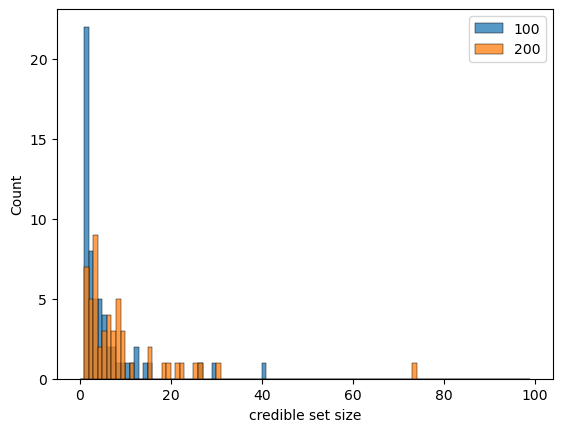

In [139]:
fig, ax = plt.subplots()
sns.histplot(sub_overlaps[100][(sub_overlaps[100]['lead_variant_id'].str.contains('chr22'))&(sub_overlaps[100]['orig_cs_dataset']=='control_eqtl')]['variant_list'].str.split(',').apply(len), bins=range(0, 100), ax=ax, label='100')
sns.histplot(sub_overlaps[200][(sub_overlaps[200]['lead_variant_id'].str.contains('chr22'))&(sub_overlaps[100]['orig_cs_dataset']=='control_eqtl')]['variant_list'].str.split(',').apply(len), bins=range(0, 100), ax=ax, label='200')
ax.set_ylabel('Count')
ax.set_xlabel('credible set size')

plt.legend()
